# 2ra parte - Modelos supervisados (Obesity - 2 Estados)

En esta fase posterior, se emplearon modelos como Naive Bayes, árboles de decisión, Random Forest y redes neuronales para discernir cuál de estos modelos supervisados ofrece estimaciones más precisas en la determinación de la obesidad de una persona, considerando tanto sus hábitos alimenticios como su estado físico. Cabe mencionar que se empleó la misma base de datos utilizada anteriormente.

# Preparación de los datos

Se empieza a realizar la importación de las librerias necesarias para el ejercicio

In [55]:
# importar librerias para el proyecto
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model, tree
from sklearn.feature_selection import RFE
from sklearn import linear_model, tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from dtreeviz.trees import dtreeviz
from sklearn.model_selection import GridSearchCV
import joblib as joblib
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, f1_score, accuracy_score, recall_score
from tabulate import tabulate
#from keras.wrappers.scikit_learn import KerasRegressor
#from scikeras.wrappers import KerasClassifier
from sklearn.metrics import roc_curve, auc


In [56]:
# Cargamos los datos  
datos = pd.read_csv("../Datos/ObesityDataSet_raw_and_data_sinthetic.csv")
datos.head(10)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II
5,Male,29.0,1.62,53.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,Normal_Weight
6,Female,23.0,1.50,55.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,0.0,Sometimes,Motorbike,Normal_Weight
7,Male,22.0,1.64,53.0,no,no,2.0,3.0,Sometimes,no,2.0,no,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
8,Male,24.0,1.78,64.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Frequently,Public_Transportation,Normal_Weight
9,Male,22.0,1.72,68.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,no,Public_Transportation,Normal_Weight


In [57]:
datos.describe()


,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


A continuación, se realizó la separición de las variables categoricas y númericas en conjunto de la separación de la base en testeo y train. Adicionalmente para la variable objetivo "NObeyesdad" se agruparon sus 6 categorias en dos, siendo el estado 1 si el individuo es obeso y 0 que no lo es.

In [58]:
datos['Age'] = round(datos['Age'] )
datos['FCVC'] = round(datos['FCVC'] )
datos['NCP'] = round(datos['NCP'] )
datos['CH2O'] = round(datos['CH2O'] )
datos['FAF'] = round(datos['FAF'] )
datos['TUE'] = round(datos['TUE'] )

In [59]:
rng = np.random.RandomState(seed=30) # Algo pasa con la semilla pero en X_train la variable CAEC queda sin always, por eso al ajustar el modelo no encuentra la categoría
categorical= ["Gender","family_history_with_overweight", "FAVC","SMOKE", "SCC","CAEC","CALC",'MTRANS']
numerical_columns = ["Age", "FCVC", "NCP", "CH2O", "FAF","TUE"]
X = datos[numerical_columns +categorical]
y = datos["NObeyesdad"]
y = pd.DataFrame(datos['NObeyesdad'].map({'Normal_Weight': 0, 'Insufficient_Weight': 0, 'Overweight_Level_I':0,'Overweight_Level_II':0, 'Obesity_Type_I':1,'Obesity_Type_II':1, 'Obesity_Type_III':1}))
yname = ["NObeyesdad"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=54)

## Preprocessing


Se aplicó la función de ColumnTransformer para llevar a cabo la transformación de los datos. En el caso de las variables categóricas, se empleó la función OneHotEncoder para su conversión a formato numérico. En cuanto a las variables numéricas, se llevó a cabo la escalación utilizando la función StandardScaler.

In [60]:
categorical_encoder = OneHotEncoder(handle_unknown='ignore') 
numerical_pipe = StandardScaler()

preprocessing = ColumnTransformer(
    [
        ("codificacion de categoricas",categorical_encoder, categorical),
        ("Transformación de numéricas", numerical_pipe, numerical_columns)
    ],
    verbose_feature_names_out=False,
)


A continuación, se realiza la estimación de los modelos supervisados y se eligira cual es el mejor para deterinar si los individuos son obesos.

# Logistic Model

Se implementó el modelo logístico mediante las funciones Pipeline y GridSearchCV con el objetivo de generar múltiples modelos logísticos y seleccionar el que obtenga el mejor rendimiento en términos de precisión (accuracy).

In [61]:
logit = LogisticRegression(random_state=30)
modelo_logit = Pipeline(
    [
    ("preprocesamiento", preprocessing),
    ("Classifier", logit),  
    ]
)

In [62]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=30)
param_grid = {'Classifier__penalty': ['l1', 'l2'],           # Tipo de penalización
              'Classifier__C': [0.001, 0.01, 0.1, 1, 10],    # Parámetro de regularización inversa (más pequeño es más fuerte)
              'Classifier__max_iter': [100, 200, 300],        # Número máximo de iteraciones
              'Classifier__fit_intercept': [True, False],     # Ajustar o no la intercepción
              'Classifier__class_weight': [None, 'balanced'] } # Manejo de clases desbalanceadas}

best_log = GridSearchCV(modelo_logit, param_grid, cv=5, scoring='accuracy')
best_log.fit(X_train, y_train)

c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-v

c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-v

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('codificacion '
                                                                         'de '
                                                                         'categoricas',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'family_history_with_overweight',
                                                                          'FAVC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'CAEC',
                                                                          'CALC',
                                                                          'MTRANS']),
                                                                        ('Transformación '
                                                                         'de '
                                                                         'numéricas',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE'])],
                                                          verbose_feature_names_out=False)),
                                       ('Classifier',
                                        LogisticRegression(random_state=30))]),
             param_grid={'Classifier__C': [0.001, 0.01, 0.1, 1, 10],
                         'Classifier__class_weight': [None, 'balanced'],
                         'Classifier__fit_intercept': [True, False],
                         'Classifier__max_iter': [100, 200, 300],
                         'Classifier__penalty': ['l1', 'l2']},
             scoring='accuracy')

Dentro de los diferentes modelos lógicticos creados, se eligio el mejor modelo con un accurency de 0.7443 con datos de testeo y de 0.7840 con datos de entrenamiento. Además, presentó un área bajo la curva (AUC) de 0.8205, bajo las siguientes especificaciones:

- 'Classifier__C': 0.1: Un valor más alto de C indica una regularización más débil, lo que significa que el modelo puede ajustarse más a los datos de entrenamiento. En este caso es una regularización relativamente fuerte.

- 'Classifier__class_weight': 'balanced': Las clases menos representadas tendrán un peso mayor para equilibrar el impacto de las clases más frecuentes durante el entrenamiento del modelo.

- 'Classifier__fit_intercept': True: Se permite que el modelo tenga un término de intercepción.

- 'Classifier__max_iter': 200: Representa el número máximo de iteraciones permitidas durante la optimización del modelo.

- 'Classifier__penalty': 'l2': Este parámetro especifica el tipo de regularización que se aplica al modelo. En este caso, 'l2' se refiere a la regularización de norma L2, que penaliza los coeficientes cuadrados grandes en la función de pérdida.


In [63]:
best_log.best_params_

{'Classifier__C': 0.1,
 'Classifier__class_weight': 'balanced',
 'Classifier__fit_intercept': True,
 'Classifier__max_iter': 100,
 'Classifier__penalty': 'l2'}

En total, se estima que del total de individuos mal clasificados (135), 34 son falsos negativos y 101 son falsos positivos, lo que resulta en una sensibilidad del 0.8601 y una precisión del 0.6742.

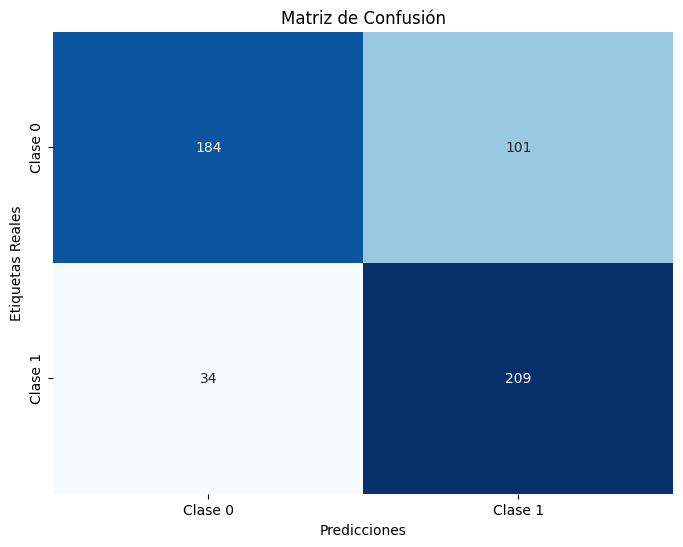

In [64]:
from sklearn.metrics import confusion_matrix

y_test1= pd.DataFrame(y_test)
y_predlog = best_log.predict(X_test)
cm = confusion_matrix(y_test1, y_predlog)
# Configuración de la matriz de confusión usando seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])],
            yticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])])

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.show()

plt.show()

In [65]:
print("Rendimiento con datos de entrenamiento",round(best_log.best_score_,4))
print("Rendimiento con datos nuevos", round(best_log.score(X_test,y_test),4))
print("Sensibilidad", round(recall_score(y_test, y_predlog),4))
print("Precisión", round(precision_score(y_test, y_predlog),4))

Rendimiento con datos de entrenamiento 0.784
Rendimiento con datos nuevos 0.7443
Sensibilidad 0.8601
Precisión 0.6742


In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_predlog))

              precision    recall  f1-score   support

           0       0.84      0.65      0.73       285
           1       0.67      0.86      0.76       243

    accuracy                           0.74       528
   macro avg       0.76      0.75      0.74       528
weighted avg       0.77      0.74      0.74       528



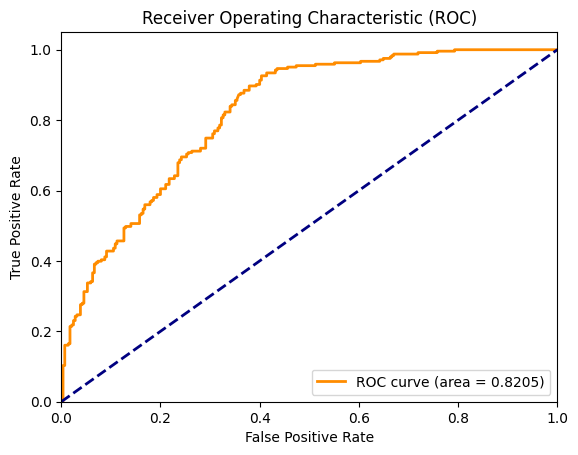

In [67]:
# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scores = best_log.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auclog = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auclog)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Arbol de decisión

Se aplicó el modelo con Arbol de decisión utilizando las funciones Pipeline y GridSearchCV, con la finalidad de crear diversos modelos y elegir aquel que logre el mejor desempeño en cuanto a precisión (accuracy).

In [68]:
arbol = DecisionTreeClassifier(random_state=30)
modelo_arbol = Pipeline(
    [
    ("preprocesamiento", preprocessing),
    ("Classifier", arbol),  
    ]
)

In [69]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=30)
param_grid = {"Classifier__criterion": ['entropy', 'gini','log_loss'],
              "Classifier__max_depth": range(2, 6),
              "Classifier__min_samples_leaf": range(2, 10)}

best_tree = GridSearchCV(modelo_arbol, param_grid, cv=k_fold, scoring='accuracy', n_jobs=-1)
best_tree.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=30, shuffle=True),
             estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('codificacion '
                                                                         'de '
                                                                         'categoricas',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'family_history_with_overweight',
                                                                          'FAVC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'CAEC',
                                                                          'CALC',
                                                                          'MTRANS']),
                                                                        ('Transformación '
                                                                         'de '
                                                                         'numéricas',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE'])],
                                                          verbose_feature_names_out=False)),
                                       ('Classifier',
                                        DecisionTreeClassifier(random_state=30))]),
             n_jobs=-1,
             param_grid={'Classifier__criterion': ['entropy', 'gini',
                                                   'log_loss'],
                         'Classifier__max_depth': range(2, 6),
                         'Classifier__min_samples_leaf': range(2, 10)},
             scoring='accuracy')

Dentro de los diferentes modelos de árbol de decisión creados, se eligio el mejor modelo con un accurency de 0.7481 con datos de testeo y de 0.7903 con datos de entrenamiento. Además, presentó un área bajo la curva (AUC) de 0.8332, bajo las siguientes especificaciones:

- clasificador__criterion: En este caso, se utiliza el índice de Gini. El índice de Gini mide la impureza de un conjunto de datos, y el algoritmo de árbol de decisión buscará las divisiones que minimicen esta impureza.

- clasificador__max_depth: Este parámetro controla la profundidad máxima del árbol de decisión. Se ha establecido en 5, lo que significa que el árbol se construirá con un máximo de 5 niveles de profundidad desde el nodo raíz hasta las hojas.

- clasificador__min_samples_leaf: Este parámetro establece el número mínimo de muestras requeridas en una hoja del árbol. Lo que significa que una hoja del árbol debe contener al menos 6 muestras.

In [70]:
best_tree.best_params_

{'Classifier__criterion': 'gini',
 'Classifier__max_depth': 5,
 'Classifier__min_samples_leaf': 6}

En total, se estima que del total de individuos mal clasificados (133), 62 son falsos negativos y 71 son falsos positivos, lo que resulta en una sensibilidad del 0.7449 y una precisión del 0.7183

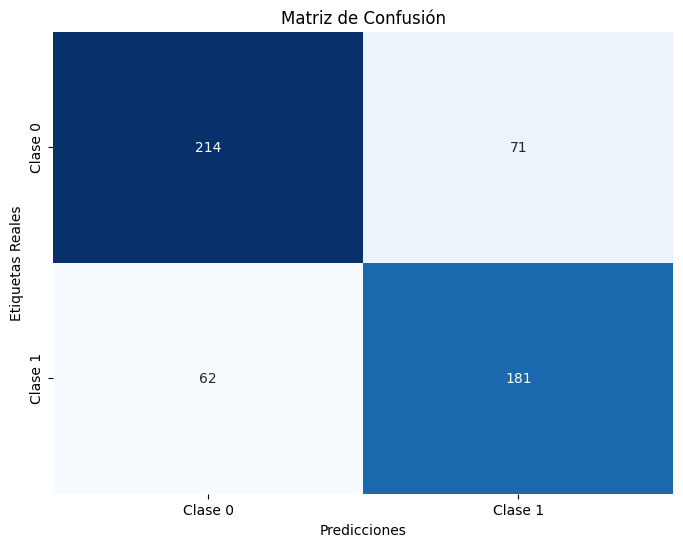

In [71]:
from sklearn.metrics import confusion_matrix

y_test1= pd.DataFrame(y_test)
y_predtree = best_tree.predict(X_test)
cm = confusion_matrix(y_test1, y_predtree)
# Configuración de la matriz de confusión usando seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])],
            yticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])])

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.show()

plt.show()

In [72]:
print("Accuracy con datos de entrenamiento",round(best_tree.best_score_,4))
print("Accuracy con datos nuevos", round(best_tree.score(X_test,y_test),4))
print("Sensibilidad", round(recall_score(y_test, y_predtree),4))
print("Precisión", round(precision_score(y_test, y_predtree),4))

Accuracy con datos de entrenamiento 0.7903
Accuracy con datos nuevos 0.7481
Sensibilidad 0.7449
Precisión 0.7183


In [73]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_predtree))

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       285
           1       0.72      0.74      0.73       243

    accuracy                           0.75       528
   macro avg       0.75      0.75      0.75       528
weighted avg       0.75      0.75      0.75       528



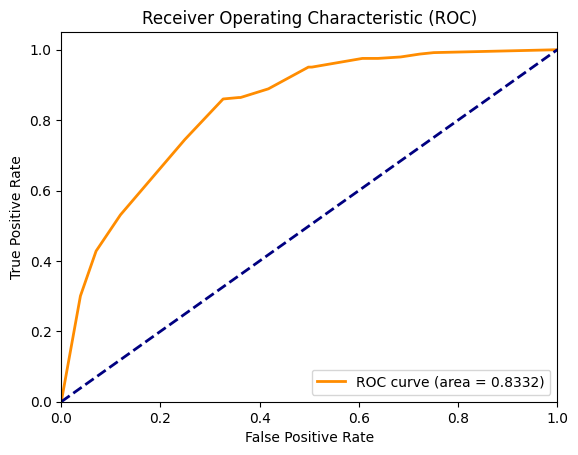

In [74]:
# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scores = best_tree.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auctree = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auctree)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Random Forest


Se utilizó la combinación de las funciones Pipeline y GridSearchCV para implementar Random Forest. El propósito fue generar diversos modelos logísticos y identificar aquel que lograra el mejor rendimiento en términos de precisión (accuracy).

In [75]:
# Random Forest
modelo=RandomForestClassifier(random_state=30)
modelo_rf = Pipeline(
    [
    ("preprocesamiento", preprocessing),
    ("clasificador", modelo),
    ]
)


In [76]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=30)
param_grid = {'clasificador__criterion': ['entropy', 'log_loss', 'gini'],
              'clasificador__max_depth': range(3, 10),
              'clasificador__min_samples_leaf': range(2, 10)}
best_rf = GridSearchCV(modelo_rf, param_grid, scoring='accuracy', n_jobs=-1)
best_rf.fit(X_train, y_train)

c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('codificacion '
                                                                         'de '
                                                                         'categoricas',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'family_history_with_overweight',
                                                                          'FAVC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'CAEC',
                                                                          'CALC',
                                                                          'MTRANS']),
                                                                        ('Transformación '
                                                                         'de '
                                                                         'numéricas',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE'])],
                                                          verbose_feature_names_out=False)),
                                       ('clasificador',
                                        RandomForestClassifier(random_state=30))]),
             n_jobs=-1,
             param_grid={'clasificador__criterion': ['entropy', 'log_loss',
                                                     'gini'],
                         'clasificador__max_depth': range(3, 10),
                         'clasificador__min_samples_leaf': range(2, 10)},
             scoring='accuracy')

Dentro de los diferentes modelos Random Forest creados, se eligio el mejor modelo con un accurency de 0.9091 con datos de testeo y de 0.8888 con datos de entrenamiento. Además, presentó un área bajo la curva (AUC) de 0.9579, bajo las siguientes especificaciones:

- clasificador__criterion: Este parámetro indica el criterio utilizado para medir la calidad de una división en el árbol de decisión. Se implemento el índice de 'Gini' el cual mide qué tan homogéneo son los nodos hijos en términos de las clases de la variable objetivo. Un valor más bajo indica una mejor división.

- clasificador__max_depth: Este parámetro controla la profundidad máxima del árbol de decisión. En tu configuración, se ha establecido en 9, lo que significa que el árbol se construirá con un máximo de 9 niveles de profundidad desde el nodo raíz hasta las hojas.

- clasificador__min_samples_leaf: Este parámetro establece el número mínimo de muestras requeridas en una hoja del árbol. Lo que significa que una hoja del árbol debe contener al menos 5 muestras.

In [77]:
best_rf.best_params_

{'clasificador__criterion': 'gini',
 'clasificador__max_depth': 9,
 'clasificador__min_samples_leaf': 5}

En total, se estima que del total de individuos mal clasificados (87), 32 son falsos negativos y 55 son falsos positivos, lo que resulta en una sensibilidad del 0.8683 y una precisión del 0.7932.

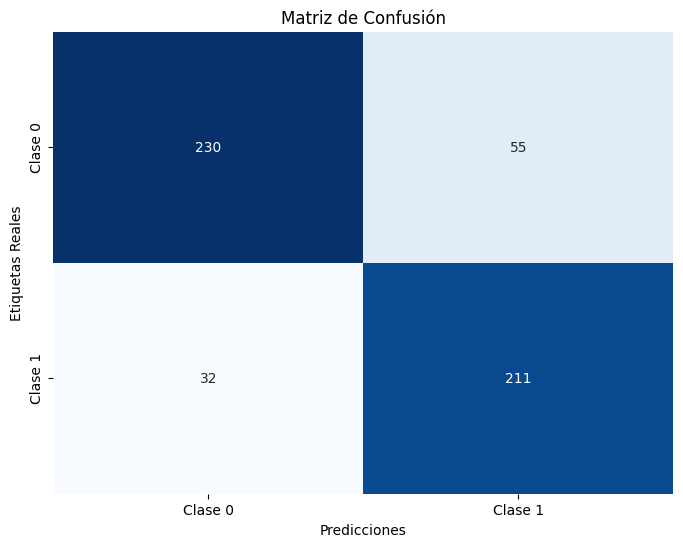

In [78]:
y_test1= pd.DataFrame(y_test)
y_predrf = best_rf.predict(X_test)
cm = confusion_matrix(y_test1, y_predrf)
# Configuración de la matriz de confusión usando seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])],
            yticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])])

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.show()

plt.show()

In [79]:
print("Accuracy con datos de entrenamiento",round(best_rf.best_score_,4))
print("Accuracy con datos nuevos", round(best_rf.score(X_test,y_test),4))
print("Sensibilidad", round(recall_score(y_test, y_predrf),4))
print("Precisión", round(precision_score(y_test, y_predrf),4))

Accuracy con datos de entrenamiento 0.8661
Accuracy con datos nuevos 0.8352
Sensibilidad 0.8683
Precisión 0.7932


In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_predrf))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       285
           1       0.79      0.87      0.83       243

    accuracy                           0.84       528
   macro avg       0.84      0.84      0.84       528
weighted avg       0.84      0.84      0.84       528



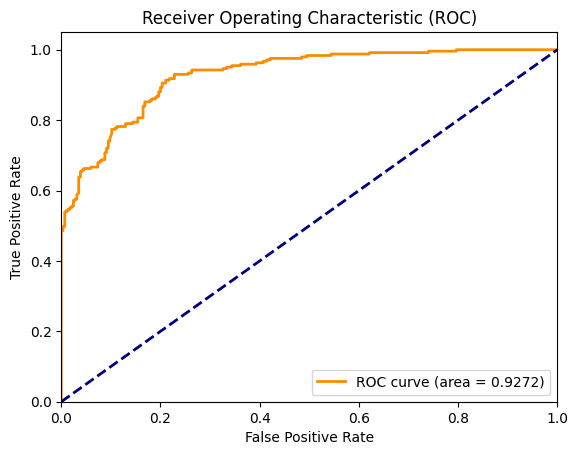

In [81]:
# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scores = best_rf.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_aucrf = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_aucrf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Naive Bayes

Se utilizó la combinación de las funciones Pipeline y GridSearchCV para implementar Naive Bayes. El propósito fue generar diversos modelos logísticos y identificar aquel que lograra el mejor rendimiento en términos de precisión (accuracy).

In [82]:
gnb=GaussianNB()
modelo_GNB = Pipeline(
    [
    ("preprocesamiento", preprocessing),
    ("Classifier", gnb),  
    ]
)

k_fold = StratifiedKFold(5, shuffle=True, random_state=54)
param_grid = {}
#param_grid ={}
best_GNB = GridSearchCV(modelo_GNB, param_grid, scoring='accuracy', n_jobs=-1)
best_GNB.fit(X_train, y_train)


c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('codificacion '
                                                                         'de '
                                                                         'categoricas',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'family_history_with_overweight',
                                                                          'FAVC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'CAEC',
                                                                          'CALC',
                                                                          'MTRANS']),
                                                                        ('Transformación '
                                                                         'de '
                                                                         'numéricas',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE'])],
                                                          verbose_feature_names_out=False)),
                                       ('Classifier', GaussianNB())]),
             n_jobs=-1, param_grid={}, scoring='accuracy')

A diferencia de otros modelos, El naive bayes no requiere de hiperparametros para su realización. Sin embargo, mediante la grilla se corrieron varios modelos y al final se escogío el modelo con un accurency de 0.7481 con datos de testeo y de 0.7663 con datos de entrenamiento. Además, presentó un área bajo la curva (AUC) de 0.8368.

En total, se estima que del total de individuos mal clasificados (133), 17 son falsos negativos y 116 son falsos positivos, lo que resulta en una sensibilidad del 0.9300 y una precisión del 0.6608.

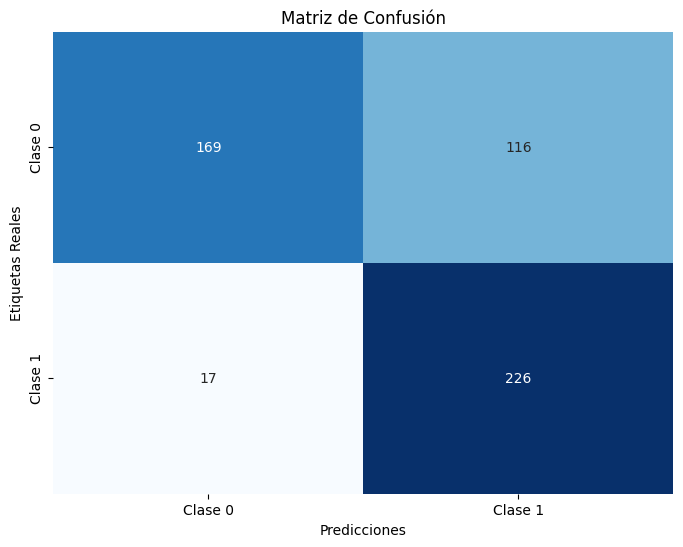

In [83]:
y_test1= pd.DataFrame(y_test)
y_predGNB = best_GNB.predict(X_test)
cm = confusion_matrix(y_test1, y_predGNB)
# Configuración de la matriz de confusión usando seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])],
            yticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])])

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.show()

plt.show()

In [84]:
print("Accuracy con datos de entrenamiento",round(best_GNB.best_score_,4))
print("Accuracy con datos nuevos", round(best_GNB.score(X_test,y_test),4))
print("Sensibilidad", round(recall_score(y_test, y_predGNB),4))
print("Precisión", round(precision_score(y_test, y_predGNB),4))

Accuracy con datos de entrenamiento 0.7663
Accuracy con datos nuevos 0.7481
Sensibilidad 0.93
Precisión 0.6608


In [85]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_predGNB))

              precision    recall  f1-score   support

           0       0.91      0.59      0.72       285
           1       0.66      0.93      0.77       243

    accuracy                           0.75       528
   macro avg       0.78      0.76      0.75       528
weighted avg       0.79      0.75      0.74       528



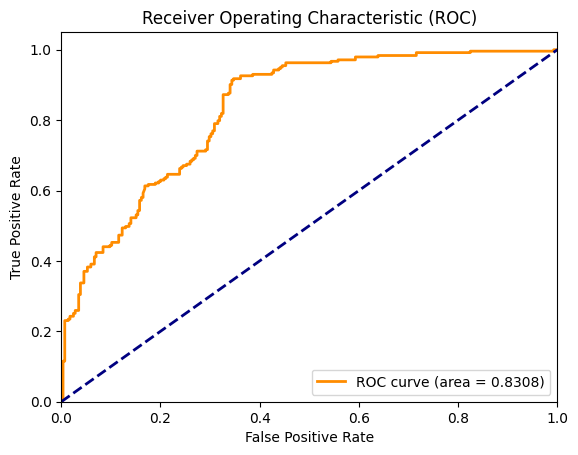

In [86]:
# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scores = best_GNB.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_aucGNB = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_aucGNB)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Redes Neuronales

Se utilizó la combinación de las funciones Pipeline y GridSearchCV para implementar Redes Neuronales. El propósito fue generar diversos modelos de Redes Neuronales y identificar aquel que lograra el mejor rendimiento en términos de precisión (accuracy).

In [105]:
red = Sequential()
red.add(Dense(128, input_shape=(28,) ,activation='softmax'))
red.add(Dense(64, input_shape=(28,) ,activation='softmax'))
red.add(Dense(32, input_shape=(28,) ,activation='tanh'))
red.add(Dense(1, input_shape=(28,) ,activation='relu'))
red.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


modelo_red = Pipeline(
    [
    ("preprocesamiento", preprocessing),
    ("Classifier", red),
    ]
)

modelo_red.fit(X_train, y_train)



c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\keras\src\losses\losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5410 - loss: 5.4726e-08


Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('codificacion de categoricas',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'CAEC', 'CALC', 'MTRANS']),
                                                 ('Transformación de numéricas',
                                                  StandardScaler(),
                                                  ['Age', 'FCVC', 'NCP', 'CH2O',
                                                   'FAF', 'TUE'])],
                                   verbose_feature_names_out=False)),
                ('Classifier', <Sequential name=sequential_3, built=True>)])

In [88]:
red_neuronal = MLPClassifier(random_state=30)
rn_mlp = Pipeline(
    [
    ("preprocessing",preprocessing),
    ("Classifier",red_neuronal)    
    ]
)

In [89]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=30)
param_grid ={ "Classifier__hidden_layer_sizes":[(10,), (20,), (30,)],
             "Classifier__activation":['identity','logistic','tanh','relu'],
             "Classifier__solver":['lbfgs','sgd','adam'],
             "Classifier__alpha":[0.0001, 0.001, 0.01, 0.1],
             "Classifier__learning_rate":['constant','invscaling','adaptative']}


best_neuralnetwork = GridSearchCV(rn_mlp, param_grid, scoring='accuracy', n_jobs=-1)
best_neuralnetwork.fit(X_train, y_train)

c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
181 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\LauraCuestas\anaconda3\envs\t

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('codificacion '
                                                                         'de '
                                                                         'categoricas',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'family_history_with_overweight',
                                                                          'FAVC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'CAEC',
                                                                          'CALC',
                                                                          'MTRANS']),
                                                                        ('Transformación '
                                                                         'de '
                                                                         'numéricas',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE'])],
                                                          verbose_f...
                                       ('Classifier',
                                        MLPClassifier(random_state=30))]),
             n_jobs=-1,
             param_grid={'Classifier__activation': ['identity', 'logistic',
                                                    'tanh', 'relu'],
                         'Classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'Classifier__hidden_layer_sizes': [(10,), (20,),
                                                            (30,)],
                         'Classifier__learning_rate': ['constant', 'invscaling',
                                                       'adaptative'],
                         'Classifier__solver': ['lbfgs', 'sgd', 'adam']},
             scoring='accuracy')

Apartir de la realización de diferentes modelos de redes neuronales, se eligio el mejor modelo con un accurency de 0.8826 con datos de testeo y de 0.8939 con datos de entrenamiento. Además, presentó un área bajo la curva (AUC) de 0.9368, bajo las siguientes especificaciones:

- Classifier__activation: 'logistic'
En este caso, se ha seleccionado la función logística (también conocida como función sigmoide). La función logística transforma la entrada en un rango entre 0 y 1.

- Classifier__alpha: 0.1
La regularización ayuda a prevenir el sobreajuste al penalizar pesos grandes. Un valor de alpha más alto implica una regularización más fuerte y el implementado en este modelo es relativamente alto.

- Classifier__hidden_layer_sizes: (30,)
Indica la arquitectura de la red neuronal, es decir, el número de neuronas en cada capa oculta. En este caso, hay una única capa oculta con 30 neuronas.

- Classifier__learning_rate: 'constant'
En este caso, se utiliza la tasa de aprendizaje 'constant', que mantiene la tasa de aprendizaje constante a medida que avanza el entrenamiento.

- Classifier__solver: 'lbfgs'
Se ha seleccionado 'lbfgs', que es un algoritmo de optimización de segundo orden bien adaptado para problemas de optimización convexa.

In [90]:
best_neuralnetwork.best_params_

{'Classifier__activation': 'logistic',
 'Classifier__alpha': 0.1,
 'Classifier__hidden_layer_sizes': (30,),
 'Classifier__learning_rate': 'constant',
 'Classifier__solver': 'lbfgs'}


En total, se estima que del total de individuos mal clasificados (62), 31 son falsos negativos y 31 son falsos positivos, lo que resulta en una sensibilidad del 0.8724 y una precisión del 0.8724.

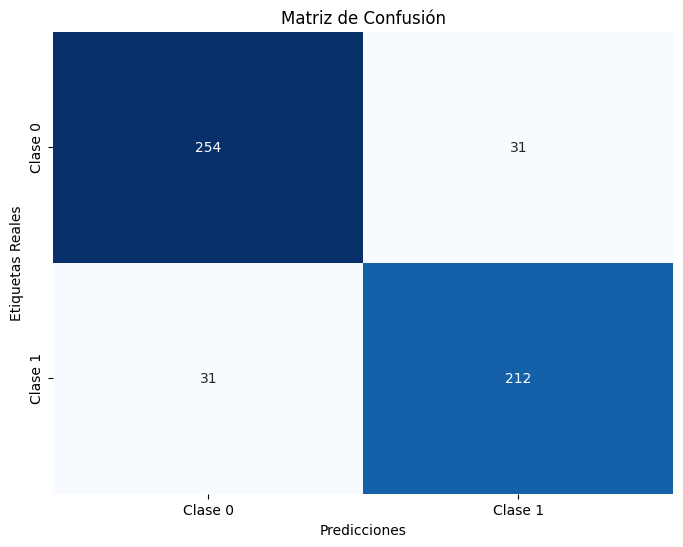

In [91]:
y_test1= pd.DataFrame(y_test)
y_predRED = best_neuralnetwork.predict(X_test)
cm = confusion_matrix(y_test1, y_predRED)
# Configuración de la matriz de confusión usando seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])],
            yticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])])

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.show()

plt.show()

In [92]:
print("Accuracy con datos de entrenamiento",round(best_neuralnetwork.best_score_,4))
print("Accuracy con datos nuevos", round(best_neuralnetwork.score(X_test,y_test),4))
print("Sensibilidad", round(recall_score(y_test, y_predRED),4))
print("Precisión", round(precision_score(y_test, y_predRED),4))

Accuracy con datos de entrenamiento 0.8939
Accuracy con datos nuevos 0.8826
Sensibilidad 0.8724
Precisión 0.8724


In [93]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_predRED))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       285
           1       0.87      0.87      0.87       243

    accuracy                           0.88       528
   macro avg       0.88      0.88      0.88       528
weighted avg       0.88      0.88      0.88       528



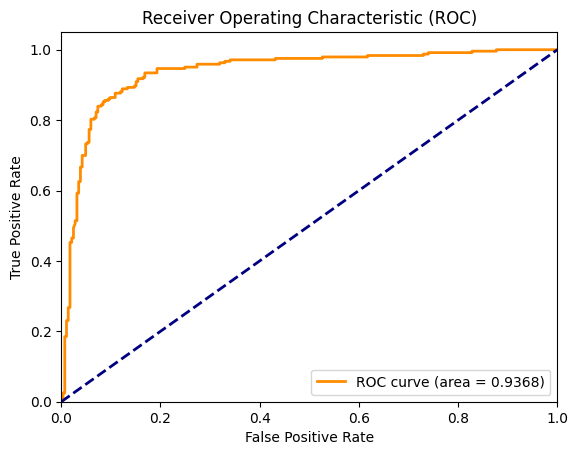

In [94]:
# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scores = best_neuralnetwork.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_aucRED = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_aucRED)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Al comparar todos los modelos mencionados anteriormente, se evidencia que la Red Neuronal muestra una precisión superior en la predicción de personas con obesidad (Precisión: 0.8724). Además, exhibe una exactitud global mayor que la de los demás modelos (Accuracy: 0.8826). Es destacable que la Red Neuronal también presenta uno de los AUC más elevados en comparación con los otros modelos. Esto sugiere una capacidad de clasificación y discriminación más sólida en relación con los diferentes estados de la variable obesidad.

In [95]:
data = {'Modelo':['Logistico', 'Arbol de decisión', 'Random Forest', 'Naive Bayes', 'Red Neuronal'],
        'Precisión':[round(precision_score(y_test, y_predlog),ndigits=4), round(precision_score(y_test, y_predtree),ndigits=4), round(precision_score(y_test, y_predrf),ndigits=4), round(precision_score(y_test, y_predGNB),ndigits=4), round(precision_score(y_test, y_predRED),ndigits=4)],
        'Sensibilidad':[round(recall_score(y_test, y_predlog),ndigits=4), round(recall_score(y_test, y_predtree),ndigits=4), round(recall_score(y_test, y_predrf),ndigits=4), round(recall_score(y_test, y_predGNB),ndigits=4), round(recall_score(y_test, y_predRED),ndigits=4)],
        'F1':[round(f1_score(y_test, y_predlog),ndigits=4), round(f1_score(y_test, y_predtree),ndigits=4), round(f1_score(y_test, y_predrf),ndigits=4), round(f1_score(y_test, y_predGNB),ndigits=4), round(f1_score(y_test, y_predRED),ndigits=4)],
        'AUC':[round(roc_auclog,ndigits=4), round(roc_auctree,ndigits=4), round(roc_aucrf,ndigits=4), round(roc_aucGNB,ndigits=4), round(roc_aucRED,ndigits=4)],
        'Accuracy':[round(best_log.score(X_test,y_test),4), round(best_tree.score(X_test,y_test),4), round(best_rf.score(X_test,y_test),4), round(best_GNB.score(X_test,y_test),4), round(best_neuralnetwork.score(X_test,y_test),4)]}
Modelo=['Logistico', 'Arbol de decisión', 'Random Forest', 'Naive Bayes', 'Red Neuronal']
data = pd.DataFrame(data, index=None)


print(tabulate(data.sort_values(by='Accuracy', ascending=False), headers='keys', tablefmt='pretty', showindex=False))

+-------------------+-----------+--------------+--------+--------+----------+
|      Modelo       | Precisión | Sensibilidad |   F1   |  AUC   | Accuracy |
+-------------------+-----------+--------------+--------+--------+----------+
|   Red Neuronal    |  0.8724   |    0.8724    | 0.8724 | 0.9368 |  0.8826  |
|   Random Forest   |  0.7932   |    0.8683    | 0.8291 | 0.9272 |  0.8352  |
| Arbol de decisión |  0.7183   |    0.7449    | 0.7313 | 0.8332 |  0.7481  |
|    Naive Bayes    |  0.6608   |     0.93     | 0.7726 | 0.8308 |  0.7481  |
|     Logistico     |  0.6742   |    0.8601    | 0.7559 | 0.8205 |  0.7443  |
+-------------------+-----------+--------------+--------+--------+----------+


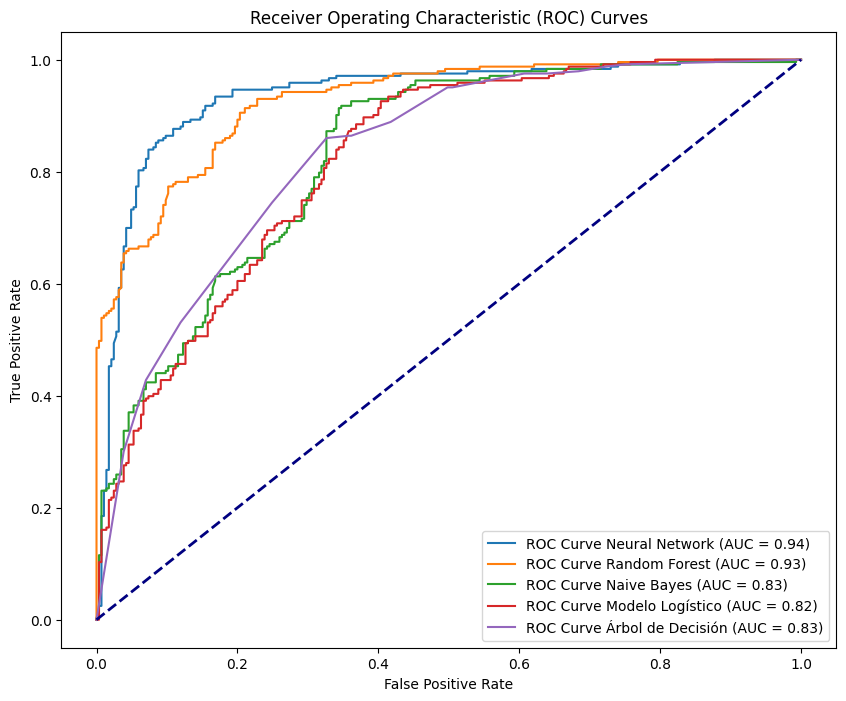

In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scoresRed = best_neuralnetwork.predict_proba(X_test)[:, 1]
y_scoresRF = best_rf.predict_proba(X_test)[:, 1]
y_scoresGNB = best_GNB.predict_proba(X_test)[:, 1]
y_scoresLog = best_log.predict_proba(X_test)[:, 1]
y_scoresTree = best_tree.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Supongamos que tienes tres conjuntos de datos de prueba y predicciones
# Guarda las tasas de verdaderos positivos (TPR) y tasas de falsos positivos (FPR) para cada conjunto
fpr1, tpr1, _ = roc_curve(y_test, y_scoresRed)
fpr2, tpr2, _ = roc_curve(y_test, y_scoresRF)
fpr3, tpr3, _ = roc_curve(y_test, y_scoresGNB)
fpr4, tpr4, _ = roc_curve(y_test, y_scoresLog)
fpr5, tpr5, _ = roc_curve(y_test, y_scoresTree)

# Calcula el área bajo la curva (AUC) para cada conjunto de datos
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)

# Crea una figura y subgráficos
fig, ax = plt.subplots(figsize=(10, 8))

# Traza las curvas ROC para cada conjunto de datos en subgráficos diferentes
ax.plot(fpr1, tpr1, label=f'ROC Curve Neural Network (AUC = {roc_auc1:.2f})')
ax.plot(fpr2, tpr2, label=f'ROC Curve Random Forest (AUC = {roc_auc2:.2f})')
ax.plot(fpr3, tpr3, label=f'ROC Curve Naive Bayes (AUC = {roc_auc3:.2f})')
ax.plot(fpr4, tpr4, label=f'ROC Curve Modelo Logístico (AUC = {roc_auc4:.2f})')
ax.plot(fpr5, tpr5, label=f'ROC Curve Árbol de Decisión (AUC = {roc_auc5:.2f})')

# Agrega la línea diagonal para la clasificación aleatoria en todos los subgráficos
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Etiqueta los ejes y agrega una leyenda
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curves')
ax.legend(loc='lower right')

# Muestra la gráfica
plt.show()

# Interpretación del Mejor modelo: Red Neuronal

En el modelo red neuronal, como se mencionó anteriormente se seleccionó el mejor modelo con los siguientes hiperparametros:

- Classifier__activation': 'logistic',
- Classifier__alpha': 0.1,
- Classifier__hidden_layer_sizes': (30,),
- Classifier__learning_rate': 'constant',
- Classifier__solver': 'lbfgs'

In [97]:
def custom_transformer(X):
    # Definir las columnas categóricas y numéricas según tu conjunto de datos
    categorical= ["Gender","family_history_with_overweight", "FAVC","SMOKE", "SCC","CAEC","CALC",'MTRANS']
    numerical_columns = ["Age", "FCVC", "NCP", "CH2O", "FAF","TUE"]

    # Crear un ColumnTransformer con las transformaciones deseadas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_columns),  # Estandarizar variables numéricas
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)  # Codificar variables categóricas
        ],
    )

    # Devolver el conjunto de datos transformado
    return preprocessor.fit_transform(X)

In [98]:
X_train2 = custom_transformer(X_train)
X_train2 = pd.DataFrame(X_train2)

In [119]:
red_neuronal = MLPClassifier(activation='logistic',
        alpha=0.1,
        hidden_layer_sizes=(30,),
        learning_rate= 'constant',
        solver='lbfgs', verbose=True,
        random_state=30)

red_neuronal.fit(X_train2, y_train)
print(best_neuralnetwork.best_score_, best_neuralnetwork.score(X_test,y_test))

c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8938645529688936 0.8825757575757576


c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [120]:

from sklearn.metrics import accuracy_score, log_loss
# Inicializar listas para almacenar precisión y pérdidas por época
accuracies = []
losses = []

# Bucle de entrenamiento por épocas
for epoch in range(1, 50):
    # Entrenar el modelo utilizando fit en lugar de partial_fit
    red_neuronal = MLPClassifier(activation='logistic',
        alpha=0.1,
        hidden_layer_sizes=(30,),
        learning_rate='invscaling',
        solver='lbfgs', verbose=True,
        random_state=30, max_iter=epoch)
    red_neuronal.fit(X_train2, y_train)

    # Calcular la precisión en el conjunto de entrenamiento
    y_pred = red_neuronal.predict(X_train2)
    accuracy = accuracy_score(y_train, y_pred)
    accuracies.append(accuracy)

    # Calcular la pérdida logarítmica (log loss) en el conjunto de entrenamiento
    y_prob = red_neuronal.predict_proba(X_train2)
    loss = log_loss(y_train, y_prob)
    losses.append(loss)


c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1101: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for e

En la función de la curva de pérdida vs precisión, se observa que a medida que el modelo adquiere más entrenamiento, las pérdidas disminuyen y la precisión aumenta con cada época. Se destaca que a partir de la décima época, este incremento en la precisión y la disminución de la pérdida es progresivo.

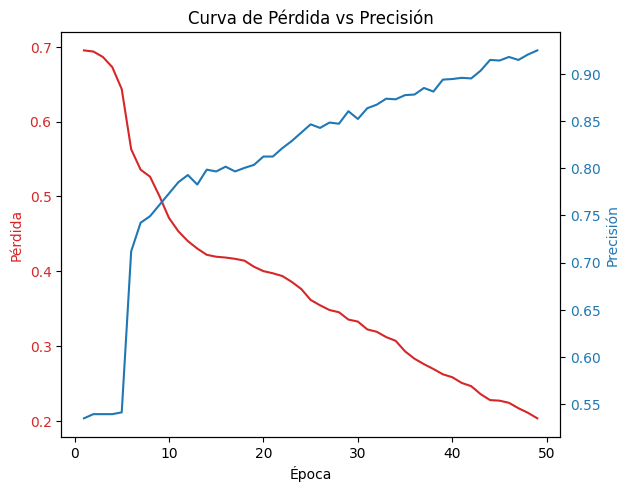

In [121]:
# Plotear la curva de pérdida versus precisión
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Época')
ax1.set_ylabel('Pérdida', color=color)
ax1.plot(range(1, red_neuronal.max_iter + 1), losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Precisión', color=color)
ax2.plot(range(1, red_neuronal.max_iter + 1), accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Curva de Pérdida vs Precisión')
plt.show()


In [125]:
primer_paso=rn_mlp['preprocessing']
primer_paso.get_feature_names_out()
primer_paso.transform(X_train)
import pandas as pd
DF=pd.DataFrame(primer_paso.transform(X_train), columns=primer_paso.get_feature_names_out())
DF.head(10)

,Gender_Female,Gender_Male,family_history_with_overweight_no,family_history_with_overweight_yes,FAVC_no,FAVC_yes,SMOKE_no,SMOKE_yes,SCC_no,SCC_yes,...,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,Age,FCVC,NCP,CH2O,FAF,TUE
0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.198360,0.961206,0.387442,-0.008244,-0.032332,-0.995844
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.198360,0.961206,-0.839200,1.441722,1.080327,-0.995844
2,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.911193,0.961206,-2.065841,-1.458209,-1.144992,-0.995844
3,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-1.149404,-0.742701,0.387442,-1.458209,-1.144992,0.484364
4,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.990897,-2.446608,0.387442,-0.008244,-1.144992,0.484364
5,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,-1.149404,-0.742701,0.387442,1.441722,1.080327,0.484364
6,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.832390,0.961206,0.387442,1.441722,-0.032332,0.484364
7,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-0.990897,0.961206,0.387442,-0.008244,-0.032332,-0.995844
8,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.277163,0.961206,0.387442,1.441722,-1.144992,-0.995844
9,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.545223,-0.742701,0.387442,1.441722,1.080327,-0.995844


El gráfico de "pesos de las conexiones de la primera capa" revela que las variables MTRANS_Walking (caminar para transportarse), SMOKE_no (no fumar) y family_history_with_overweight_no (sin antecedentes familiares de sobrepeso) tienen una influencia significativa en la clasificación de personas como no obesas. Por el contrario, se observa que las variables FAVC_yes (consumo frecuente de comidas con alto contenido calórico), Age (edad) y MTRANS_Public_Transportation (uso de transporte público) tienen una influencia más marcada en la clasificación de personas como obesas.

Capa 0:
[ 0.47497341  2.00147119  2.10418273 -0.95864401 -1.41475075 -1.08626876
 -0.0570937   1.75877148  0.91770156 -0.92107116  0.96866248 -1.11486466
  1.64010475  0.18247367  1.33520527 -4.26673408 -1.73685734 -1.49426198
  2.3242828   2.77966448  1.65647487 -0.89872024  0.59549867 -2.40287039
  3.48000336  3.10820168 -2.0786998   0.01159277 -3.83012176  1.51618824]
Capa 1:
[-0.16778871 -0.55435233 -0.9165768  -3.35852195  0.69327778  0.80886947
  1.59286995 -0.2044448   1.10227984 -0.7922996   0.3329548  -0.49861749
 -0.18461846  0.44949042 -0.55156263  0.73397738 -2.37592569 -2.8284878
  1.03269822  1.64744555  0.68302854  1.08712585  0.62995055  0.38192173
  2.61299563  0.2364086  -0.248168   -0.15669487 -1.84570827 -0.53422823]
Capa 2:
[ 2.28257646  0.10240224  0.72422863  1.71871986 -0.52532291  3.11215716
 -0.78618494 -1.05239586 -0.10691393 -0.04217113 -0.31109717  0.58143546
  0.64079528 -1.03334308 -3.8520581  -3.39263773 -1.18897923  1.9412975
  0.90331092  0.67006579  3

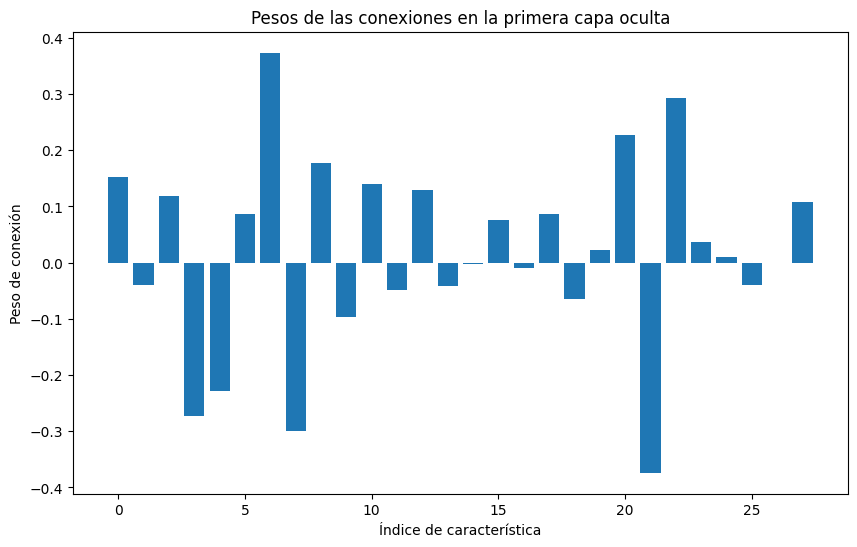

In [124]:
import numpy as np

# Obtener los pesos de las conexiones entre las neuronas
weights = red_neuronal.coefs_[0]
mean_weights = weights.mean(axis=1)
x = np.arange(len(mean_weights))


# Mostrar los pesos
for i, layer_weights in enumerate(weights):
    print(f'Capa {i}:')
    print(layer_weights)

plt.figure(figsize=(10, 6))
plt.bar(x, mean_weights)
plt.xlabel('Índice de característica')
plt.ylabel('Peso de conexión')
plt.title('Pesos de las conexiones en la primera capa oculta')
plt.show()
